In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,248 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LoanDefaultPrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

spark


In [4]:
# Performance Optimization: Spark Configuration
spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)


In [5]:
df = spark.read.csv(
    "Loan_default.csv",
    header=True,
    inferSchema=True
)

df.printSchema()


root
 |-- LoanID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- MonthsEmployed: integer (nullable = true)
 |-- NumCreditLines: integer (nullable = true)
 |-- InterestRate: double (nullable = true)
 |-- LoanTerm: integer (nullable = true)
 |-- DTIRatio: double (nullable = true)
 |-- Education: string (nullable = true)
 |-- EmploymentType: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HasMortgage: string (nullable = true)
 |-- HasDependents: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- HasCoSigner: string (nullable = true)
 |-- Default: integer (nullable = true)



In [6]:
df.show(5)
print("Total records:", df.count())
from pyspark.sql.functions import col

# Giả sử cột target là 'default'
df.groupBy("default").count().show()


+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|        Yes|          Yes|      Other|        Yes|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|         No|           N

# **Clean Data**

In [7]:
from pyspark.sql.functions import col, when

# Select needed columns
selected_cols = [
    "Age","Income","LoanAmount","CreditScore",
    "MonthsEmployed","NumCreditLines","InterestRate",
    "LoanTerm","DTIRatio",
    "Education","EmploymentType","MaritalStatus",
    "HasMortgage","HasDependents","LoanPurpose","HasCoSigner",
    "Default"
]

df_clean = df.select(*selected_cols)

# Rename label column
df_clean = df_clean.withColumnRenamed("Default", "label")

# Convert Yes / No → 1 / 0
binary_cols = ["HasMortgage", "HasDependents", "HasCoSigner"]

for c in binary_cols:
    df_clean = df_clean.withColumn(
        c,
        when(col(c) == "Yes", 1)
        .when(col(c) == "No", 0)
        .otherwise(0)
    )


# **CREATE FEATURES**

In [8]:
from pyspark.sql.functions import col, when

df_fe = df_clean \
.withColumn(
    "DebtToIncomeRatio",
    when(col("Income") > 0, col("LoanAmount") / col("Income")).otherwise(0)
) \
.withColumn(
    "CreditUtilization",
    when(col("CreditScore") > 0, col("LoanAmount") / (col("CreditScore") * 1000)).otherwise(0)
) \
.withColumn(
    "EmploymentStability",
    when(col("Age") > 0, col("MonthsEmployed") / (col("Age") * 12)).otherwise(0)
) \
.withColumn(
    "PaymentHistory",
    when(
        (col("CreditScore") >= 700) & (col("NumCreditLines") >= 3),
        1
    ).otherwise(0)
)


# **ENCODE CATEGORICAL FEATURES**

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

cat_cols = [
    "Education",
    "EmploymentType",
    "MaritalStatus",
    "LoanPurpose"
]

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=c + "_idx",
        handleInvalid="keep"
    )
    for c in cat_cols
]

encoders = [
    OneHotEncoder(
        inputCol=c + "_idx",
        outputCol=c + "_ohe"
    )
    for c in cat_cols
]


# **ASSEMBLE NUMERIC FEATURES**

In [10]:
from pyspark.ml.feature import Imputer, VectorAssembler

num_cols = [
    "Age","Income","LoanAmount","CreditScore",
    "MonthsEmployed","NumCreditLines","InterestRate",
    "LoanTerm","DTIRatio",
    "DebtToIncomeRatio","CreditUtilization","EmploymentStability"
]

num_imputer = Imputer(
    inputCols=num_cols,
    outputCols=[c + "_imp" for c in num_cols]
)

num_assembler = VectorAssembler(
    inputCols=[c + "_imp" for c in num_cols],
    outputCol="num_vec"
)


# **SCALE NUMERIC FEATURES**

In [11]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="num_vec",
    outputCol="num_scaled",
    withMean=True,
    withStd=True
)


# **FINAL ASSEMBLE**

In [12]:
final_assembler = VectorAssembler(
    inputCols=
        ["num_scaled"] +
        [c + "_ohe" for c in cat_cols] +
        [
            "HasMortgage",
            "HasDependents",
            "HasCoSigner"
        ],
    outputCol="features"
)


# **TRAIN / TEST SPLIT**

In [13]:
from pyspark.sql.functions import col

df_0 = df_fe.filter(col("label") == 0)
df_1 = df_fe.filter(col("label") == 1)

min_count = min(df_0.count(), df_1.count())

df_balanced = df_0.sample(False, min_count / df_0.count(), seed=42) \
    .union(
        df_1.sample(False, min_count / df_1.count(), seed=42)
    )

train_df, test_df = df_balanced.randomSplit([0.8, 0.2], seed=42)


In [14]:
# Performance Optimization: Cache datasets
train_df = train_df.cache()
test_df = test_df.cache()

# Trigger caching
train_df.count()
test_df.count()


11762

# **LOGISTIC REGRESSION MODEL**

In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=50
)

pipeline_lr = Pipeline(stages=
    indexers +
    encoders +
    [
        num_imputer,
        num_assembler,
        scaler,
        final_assembler,
        lr
    ]
)

lr_model = pipeline_lr.fit(train_df)
lr_pred = lr_model.transform(test_df)


# **DECISION TREE MODEL**

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=5
)

dt_pipeline = Pipeline(stages=
    indexers +
    encoders +
    [
        num_imputer,
        num_assembler,
        scaler,
        final_assembler,
        dt
    ]
)

dt_model = dt_pipeline.fit(train_df)
dt_pred = dt_model.transform(test_df)


# **RANDOM FOREST (ENSEMBLE)**

In [17]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=8
)

rf_pipeline = Pipeline(stages=
    indexers +
    encoders +
    [
        num_imputer,
        num_assembler,
        scaler,
        final_assembler,
        rf
    ]
)

rf_model = rf_pipeline.fit(train_df)
rf_pred = rf_model.transform(test_df)


# **GRADIENT BOOSTED TREES**

In [18]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=50,
    maxDepth=5
)

gbt_pipeline = Pipeline(stages=
    indexers +
    encoders +
    [
        num_imputer,
        num_assembler,
        scaler,
        final_assembler,
        gbt
    ]
)

gbt_model = gbt_pipeline.fit(train_df)
gbt_pred = gbt_model.transform(test_df)


# **EVALUATION METRICS (ACCURACY, PRECISION, RECALL, F1)**

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_classification(pred_df, model_name):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )

    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision"
    )

    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )

    print(f"🔹 {model_name}")
    print("Accuracy :", evaluator_acc.evaluate(pred_df))
    print("Precision:", evaluator_precision.evaluate(pred_df))
    print("Recall   :", evaluator_recall.evaluate(pred_df))
    print("F1-score :", evaluator_f1.evaluate(pred_df))
    print("-"*40)


# **ROC AUC**

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

def evaluate_auc(pred_df, model_name):
    auc = roc_evaluator.evaluate(pred_df)
    print(f"{model_name} ROC AUC: {auc}")


# **EVALUATE ALL MODELS**

In [21]:
evaluate_classification(lr_pred, "Logistic Regression")
evaluate_auc(lr_pred, "Logistic Regression")

evaluate_classification(dt_pred, "Decision Tree")
evaluate_auc(dt_pred, "Decision Tree")

evaluate_classification(rf_pred, "Random Forest")
evaluate_auc(rf_pred, "Random Forest")

evaluate_classification(gbt_pred, "Gradient Boosted Trees")
evaluate_auc(gbt_pred, "Gradient Boosted Trees")


🔹 Logistic Regression
Accuracy : 0.6953749362353341
Precision: 0.6954516975000773
Recall   : 0.6953749362353341
F1-score : 0.695346826109988
----------------------------------------
Logistic Regression ROC AUC: 0.7606896886520231
🔹 Decision Tree
Accuracy : 0.6621322904267981
Precision: 0.6621830696142954
Recall   : 0.6621322904267981
F1-score : 0.6621078763258956
----------------------------------------
Decision Tree ROC AUC: 0.5921930991060961
🔹 Random Forest
Accuracy : 0.6780309471178371
Precision: 0.6783008120657574
Recall   : 0.6780309471178372
F1-score : 0.6779130946615415
----------------------------------------
Random Forest ROC AUC: 0.7417425705897307
🔹 Gradient Boosted Trees
Accuracy : 0.6839823159326646
Precision: 0.6842418015262575
Recall   : 0.6839823159326646
F1-score : 0.6838747247341397
----------------------------------------
Gradient Boosted Trees ROC AUC: 0.7485316018197687


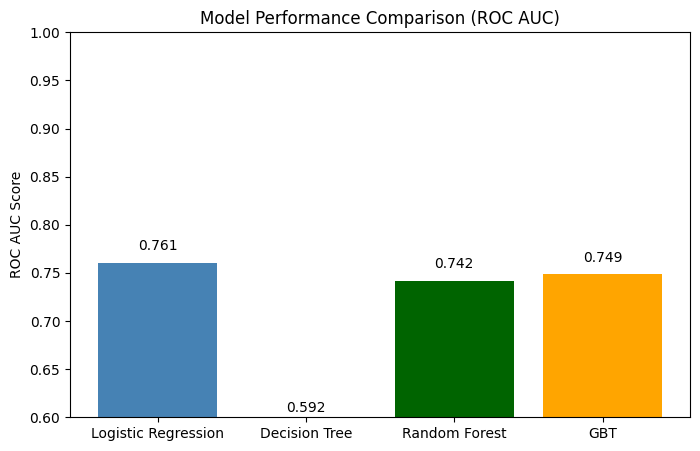

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "GBT"],
    "ROC_AUC": [
        roc_evaluator.evaluate(lr_pred),
        roc_evaluator.evaluate(dt_pred),
        roc_evaluator.evaluate(rf_pred),
        roc_evaluator.evaluate(gbt_pred)
    ]
}

metrics_df = pd.DataFrame(metrics)

# Replace NaN (Decision Tree) to 0 for visualization
metrics_df["ROC_AUC"] = metrics_df["ROC_AUC"].fillna(0)

plt.figure(figsize=(8,5))

colors = ["steelblue", "gray", "darkgreen", "orange"]
bars = plt.bar(metrics_df["Model"], metrics_df["ROC_AUC"], color=colors)

plt.ylabel("ROC AUC Score")
plt.title("Model Performance Comparison (ROC AUC)")
plt.ylim(0.6, 1.0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom"
        )

plt.show()


# **CROSS VALIDATION**

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid,
    evaluator=roc_evaluator,
    numFolds=3,
    parallelism=2
)

cv_model = crossval.fit(train_df)
cv_pred = cv_model.transform(test_df)

print("Logistic Regression CV ROC AUC:",
      roc_evaluator.evaluate(cv_pred))


Logistic Regression CV ROC AUC: 0.760364963358028


# **Check OverFitting**

In [24]:
train_pred = cv_model.transform(train_df)

train_auc = roc_evaluator.evaluate(train_pred)
test_auc = roc_evaluator.evaluate(cv_pred)

print("Train ROC AUC:", train_auc)
print("Test  ROC AUC:", test_auc)


Train ROC AUC: 0.7580214843634
Test  ROC AUC: 0.7603553207718337


In [25]:
auc_gap = train_auc - test_auc
print("AUC Gap (Train - Test):", auc_gap)


AUC Gap (Train - Test): -0.002333836408433654


# **LOAD TRAINED MODEL (BEST MODEL)**

In [26]:
# Use the best trained model from Cross Validation
best_model = cv_model.bestModel
print(best_model)


PipelineModel_dc1dd431bc5b


# **REAL-TIME DATA INGESTION (STREAMING)**

In [27]:
import os

os.makedirs("/content/stream/input", exist_ok=True)


In [28]:
from pyspark.sql.types import *

stream_schema = StructType([
    StructField("Age", IntegerType()),
    StructField("Income", IntegerType()),
    StructField("LoanAmount", IntegerType()),
    StructField("CreditScore", IntegerType()),
    StructField("MonthsEmployed", IntegerType()),
    StructField("NumCreditLines", IntegerType()),
    StructField("InterestRate", DoubleType()),
    StructField("LoanTerm", IntegerType()),
    StructField("DTIRatio", DoubleType()),
    StructField("Education", StringType()),
    StructField("EmploymentType", StringType()),
    StructField("MaritalStatus", StringType()),
    StructField("HasMortgage", StringType()),
    StructField("HasDependents", StringType()),
    StructField("LoanPurpose", StringType()),
    StructField("HasCoSigner", StringType())
])


In [29]:
stream_df = spark.readStream \
    .schema(stream_schema) \
    .option("header", "true") \
    .csv("/content/stream/input")


# **REAL-TIME PREDICTION**

In [30]:
from pyspark.sql.functions import col, when

stream_clean = stream_df \
.withColumn(
    "DebtToIncomeRatio",
    when(col("Income") > 0, col("LoanAmount") / col("Income")).otherwise(0)
) \
.withColumn(
    "CreditUtilization",
    when(col("CreditScore") > 0,
         col("LoanAmount") / (col("CreditScore") * 1000)
    ).otherwise(0)
) \
.withColumn(
    "EmploymentStability",
    when(col("Age") > 0, col("MonthsEmployed") / (col("Age") * 12)).otherwise(0)
) \
.withColumn(
    "PaymentHistory",
    when(
        (col("CreditScore") >= 700) & (col("NumCreditLines") >= 3),
        1
    ).otherwise(0)
) \
.withColumn("HasMortgage",
    when(col("HasMortgage") == "Yes", 1)
    .when(col("HasMortgage") == "No", 0)
    .otherwise(0)
) \
.withColumn("HasDependents",
    when(col("HasDependents") == "Yes", 1)
    .when(col("HasDependents") == "No", 0)
    .otherwise(0)
) \
.withColumn("HasCoSigner",
    when(col("HasCoSigner") == "Yes", 1)
    .when(col("HasCoSigner") == "No", 0)
    .otherwise(0)
)


In [31]:
predictions = best_model.transform(stream_clean)


# **Start Stream**

# **Import Test file**

In [41]:
import pandas as pd

df = pd.read_csv("/content/Loan_default.csv")

df.to_csv(
    "/content/stream/input/test8.csv",
    index=False
)


In [ ]:

for q in spark.streams.active:
    if q.name == "loan_monitor":
        q.stop()


# **Visualization Real-Time Monitoring Dashboard**

In [ ]:

stream_monitor = predictions \
    .groupBy("prediction") \
    .count()


monitor_query = stream_monitor.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("loan_monitor") \
    .option("checkpointLocation", "/tmp/loan_monitor_checkpoint") \
    .start()

import time
time.sleep(10)

import shutil

shutil.copy(
    "/content/Loan_default.csv",
    "/content/stream/input/batch_01.csv"
)

time.sleep(15)

df_monitor = spark.sql("""
SELECT prediction, count
FROM loan_monitor
ORDER BY prediction
""").toPandas()

df_monitor


,prediction,count
0,0.0,10637
1,1.0,244710


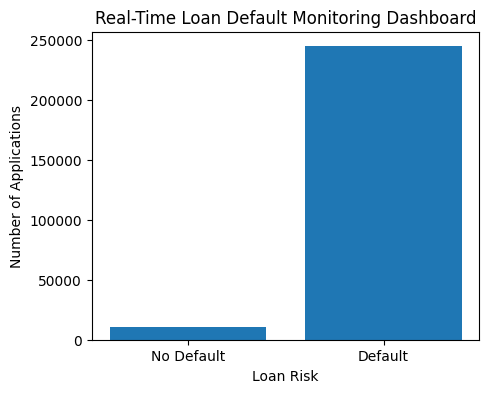

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(df_monitor["prediction"], df_monitor["count"])
plt.xticks([0,1], ["No Default", "Default"])
plt.xlabel("Loan Risk")
plt.ylabel("Number of Applications")
plt.title("Real-Time Loan Default Monitoring Dashboard")
plt.show()

# **High-Risk Loan Alert System**

In [32]:
alerts = predictions \
    .filter(col("prediction") == 1) \
    .select(
        "Age",
        "Income",
        "LoanAmount",
        "CreditScore",
        "probability"
    )

alert_query = alerts \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", "false") \
    .start()


# **Select important Column**

In [34]:
stream_result = predictions.select(
    "Age",
    "Income",
    "LoanAmount",
    "CreditScore",
    "prediction",
    "probability"
)

# **Classification Risk**

In [35]:
from pyspark.sql.functions import when

stream_result = stream_result.withColumn(
    "RiskLevel",
    when(col("prediction") == 1, "HIGH_RISK")
    .otherwise("LOW_RISK")
)


# **ALERTING MECHANISM**

In [36]:
high_risk_alerts = stream_result.filter(col("prediction") == 1)

# **Display Real-Time Alert**

In [37]:
alert_query = high_risk_alerts.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .start()

# **Display All Predictions**

In [38]:
all_pred_query = stream_result.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .start()


# **Visualization for loan default alert**

In [39]:
alert_monitor = stream_result.groupBy("RiskLevel").count()


In [40]:
alert_monitor.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("loan_alert_dashboard") \
    .start()

In [42]:
import pandas as pd

df_alerts = spark.sql("""
SELECT RiskLevel, count
FROM loan_alert_dashboard
""").toPandas()

df_alerts

,RiskLevel,count
0,HIGH_RISK,9915
1,LOW_RISK,424


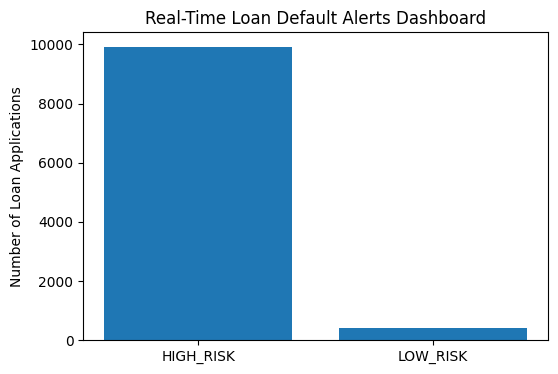

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(df_alerts["RiskLevel"], df_alerts["count"])
plt.ylabel("Number of Loan Applications")
plt.title("Real-Time Loan Default Alerts Dashboard")
plt.show()